# Projeto Final - Aprendizagem de Máquina 2025-2

Fluxo:
1. FASE 1: Executa busca de hiperparâmetros para LightGBM, XGBoost, CatBoost, SAINT e ASKL2 e salva `best_params`.
2. FASE 2: Para cada dataset e cada modelo, instanciamos a partir dos `best_params`, treinamos no conjunto de treino completo, geramos `y_pred`, `y_prob`, calculamos `runtime` e salvamos os artefatos em `artifacts/` e o modelo em `trained_models/`.
3. Model comparison: Agrupamos os artefatos salvos para calcular métricas agregadas e exportar `evaluation_results.csv`.

## Modelos Implementados

- **Modelos Clássicos (Baselines)**: LightGBM, XGBoost, CatBoost
- **AutoML**: AutoGluon, Auto-Sklearn 2.0 (ASKL2)
- **Modelo Deep Learning**: SAINT (Self-Attention and Intersample Transformer)

**Referência do SAINT:** https://github.com/Actis92/lit-saint

## Instalando os pacotes

É necessário instalar as dependências na ordem descrita para funcionar. É utilizado o `python 3.8` para instalar o SAINT corretamente. Aqui são instalados os seguintes pacotes:
- `lit-saint`: Implementação do modelo SAINT.
- `openml`: Biblioteca para carregar os datasets do OpenML.
- `autogluon`: Modelo de automl utilizado para comparação.
- `lightgbm`, `xgboost` e `catboost`: Modelos clássicos para comparação.
- `auto-sklearn`: Modelo de automl utilizado para comparação.
- `scikit-learn`: Biblioteca de machine learning.
- `seaborn` e `matplotlib`: Bibliotecas para visualização dos resultados.
- `scikit-posthocs`: Biblioteca para testes estatísticos pós-hoc.

In [ ]:
%pip install spacy==3.7.0 spacy-legacy==3.0.12 pandas==1.5.3 openml==0.14.2 \
    lit-saint==0.4.1 lightgbm==3.3.5 xgboost==1.7.6 catboost==1.2.5 autogluon==0.8.3

In [ ]:
%pip install auto-sklearn==0.15.0 numpy==1.24.4 matplotlib==3.7.5 \
    seaborn==0.13.2 scikit-posthocs==0.8.0 scipy==1.10.1

## Configurando o ambiente

Faz as seguintes alterações:
1. Ignora avisos para manter o notebook limpo.
2. Define uma semente aleatória para garantir reprodutibilidade.
3. Define o máximo de iterações na busca de hiperparâmetros.
4. Define o número de folds para o cross validation.

In [1]:
import pathlib

RANDOM_STATE = 42
N_JOBS = -1

SEARCH_ITERATIONS = 2
CV_FOLDS = 5

DATASETS_PATH = pathlib.Path('./datasets')
OPENML_CC18_ID = 99
NUM_DATASETS = 3

# Diretórios para armazenamento
TRAINED_MODELS_DIR = pathlib.Path('trained_models')
TRAINED_MODELS_DIR.mkdir(exist_ok=True)

MODEL_KEY_MAP = {
    'LightGBM': 'lightgbm',
    'XGBoost': 'xgboost',
    'CatBoost': 'catboost',
    'SAINT': 'saint',
    'AutoGluon': 'autogluon',
    'ASKL2': 'askl2'
}

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import json
import pickle
import time

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

warnings.filterwarnings('ignore')
np.random.seed(RANDOM_STATE)

## Funções Utilitárias para Salvar/Carregar Modelos

In [ ]:
from typing import Any, Dict, Iterable, List, Mapping, Optional
from datetime import datetime, timezone
from dataclasses import dataclass
from pathlib import Path
import re

ARTIFACT_ROOT = Path("artifacts")
ARTIFACT_VERSION = 1

@dataclass
class ArtifactBundle:
    """Container usado ao ler artefatos do disco."""
    model_key: str
    dataset_name: str
    dataset_slug: str
    metadata: Dict[str, Any]
    arrays: Dict[str, np.ndarray]
    path: Path

def _slugify(value: str) -> str:
    value = value.strip().lower()
    value = re.sub(r"[^a-z0-9]+", "-", value)
    value = re.sub(r"-+", "-", value).strip("-")
    return value or "dataset"

def _ensure_dir(path: Path) -> None:
    path.mkdir(parents=True, exist_ok=True)

def _as_serializable(obj: Any) -> Any:
    if isinstance(obj, np.generic):
        return obj.item()
    if isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    return obj

def get_dataset_dir(model_key: str, dataset_name: str) -> Path:
    slug = _slugify(dataset_name)
    return ARTIFACT_ROOT / model_key.lower() / slug

def artifact_exists(model_key: str, dataset_name: str) -> bool:
    dataset_dir = get_dataset_dir(model_key, dataset_name)
    return (
        dataset_dir.joinpath('metadata.json').exists()
        and dataset_dir.joinpath('predictions.npz').exists()
    )

def artifact_output_dir(model_key: str, dataset_name: str) -> str:
    return str(get_dataset_dir(model_key, dataset_name))

def write_artifact_bundle(
    *,
    model_key: str,
    dataset_name: str,
    y_true: np.ndarray,
    y_pred: Optional[np.ndarray],
    y_prob: Optional[np.ndarray],
    class_labels: Iterable[Any],
    metrics: Mapping[str, Any],
    hyperparams: Optional[Mapping[str, Any]] = None,
    runtime_seconds: Optional[float] = None,
    sample_ids: Optional[Iterable[Any]] = None,
    extra_metadata: Optional[Mapping[str, Any]] = None,
) -> Path:
    """Escreve metadados + arrays de predição para uma combinação dataset/modelo."""
    dataset_dir = get_dataset_dir(model_key, dataset_name)
    _ensure_dir(dataset_dir)

    metadata: Dict[str, Any] = {
        "artifact_version": ARTIFACT_VERSION,
        "model_key": model_key,
        "dataset_name": dataset_name,
        "dataset_slug": dataset_dir.name,
        "timestamp_utc": datetime.now(timezone.utc).isoformat(),
        "class_labels": list(class_labels),
        "metrics": {k: _as_serializable(v) for k, v in metrics.items()},
    }

    if hyperparams is not None:
        metadata["hyperparams"] = {
            k: _as_serializable(v) for k, v in hyperparams.items()
        }
    if runtime_seconds is not None:
        metadata["runtime_seconds"] = float(runtime_seconds)
    if extra_metadata:
        metadata.update({k: _as_serializable(v) for k, v in extra_metadata.items()})

    metadata_path = dataset_dir / "metadata.json"
    with metadata_path.open("w", encoding="utf-8") as fp:
        json.dump(metadata, fp, indent=2, ensure_ascii=False)

    arrays: Dict[str, np.ndarray] = {
        "y_true": np.asarray(y_true),
    }
    if y_pred is not None:
        arrays["y_pred"] = np.asarray(y_pred)
    if y_prob is not None:
        arrays["y_prob"] = np.asarray(y_prob)
    if sample_ids is not None:
        arrays["sample_ids"] = np.asarray(list(sample_ids))

    np.savez_compressed(dataset_dir / "predictions.npz", **arrays)
    return dataset_dir

def load_artifact_bundle(model_key: str, dataset_name: Optional[str] = None) -> List[ArtifactBundle]:
    """Carrega todos os artefatos armazenados para ``model_key`` (opcionalmente filtrados)."""
    base_dir = ARTIFACT_ROOT / model_key.lower()
    if not base_dir.exists():
        return []

    bundles: List[ArtifactBundle] = []
    for dataset_dir in sorted(base_dir.iterdir()):
        if not dataset_dir.is_dir():
            continue
        if dataset_name and _slugify(dataset_name) != dataset_dir.name:
            continue
        metadata_path = dataset_dir / "metadata.json"
        predictions_path = dataset_dir / "predictions.npz"
        if not metadata_path.exists() or not predictions_path.exists():
            continue
        with metadata_path.open("r", encoding="utf-8") as fp:
            metadata = json.load(fp)
        arrays = dict(np.load(predictions_path, allow_pickle=False))
        bundles.append(
            ArtifactBundle(
                model_key=model_key,
                dataset_name=metadata.get("dataset_name", dataset_dir.name),
                dataset_slug=dataset_dir.name,
                metadata=metadata,
                arrays=arrays,
                path=dataset_dir,
            )
        )
    return bundles

def load_all_artifacts() -> Dict[str, List[ArtifactBundle]]:
    """Retorna todos os artefatos armazenados agrupados por chave do modelo."""
    artifacts: Dict[str, List[ArtifactBundle]] = {}
    if not ARTIFACT_ROOT.exists():
        return artifacts
    for model_dir in ARTIFACT_ROOT.iterdir():
        if not model_dir.is_dir():
            continue
        model_key = model_dir.name
        artifacts[model_key] = load_artifact_bundle(model_key)
    return artifacts

def save_trained_model(model_key, dataset_name, model, hyperparams):
    """Salva modelo treinado + hiperparâmetros."""
    model_dir = TRAINED_MODELS_DIR / model_key
    model_dir.mkdir(parents=True, exist_ok=True)
    
    # Salva modelo
    model_path = model_dir / f"{dataset_name}_model.pkl"
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    
    # Salva metadados
    meta_path = model_dir / f"{dataset_name}_meta.json"
    metadata = {
        'model_key': model_key,
        'dataset_name': dataset_name,
        'hyperparameters': hyperparams,
    }
    with open(meta_path, 'w') as f:
        json.dump(metadata, f, indent=2, default=str)
    
    print(f"  → Modelo salvo: {model_path}")
    return model_path

def load_trained_model(model_key, dataset_name):
    """Carrega modelo treinado + hiperparâmetros."""
    model_dir = TRAINED_MODELS_DIR / model_key
    model_path = model_dir / f"{dataset_name}_model.pkl"
    meta_path = model_dir / f"{dataset_name}_meta.json"
    
    if not model_path.exists():
        return None, None
    
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    
    with open(meta_path, 'r') as f:
        metadata = json.load(f)
    
    return model, metadata

## Carregamento de Dados

Carrega os 30 menores datasets do OpenML para tarefas de classificação do CC18.

Esses datasets são salvos em um mapping onde a chave é o nome do dataset e o valor é o dataframe com as devidas features e um campo 'target' para as predições verdadeiras.

In [3]:
import openml

if not DATASETS_PATH.exists():
    print("Fetching datasets from OpenML...")
    suite = openml.study.get_suite(suite_id=OPENML_CC18_ID)
    datasets_df = openml.datasets.list_datasets(data_id=suite.data, output_format='dataframe')

    datasets_df_sorted = datasets_df.sort_values(by='NumberOfInstances')
    top_datasets = datasets_df_sorted.head(NUM_DATASETS)

    datasets_memory = {}
    for idx, row in top_datasets.iterrows():
        dataset_id = row['did']
        dataset_name = row['name']
        print(f"Fetching {dataset_name} (ID: {dataset_id})...")
        try:
            dataset = openml.datasets.get_dataset(dataset_id)
            X, y, _, _ = dataset.get_data(
                target=dataset.default_target_attribute,
                dataset_format='dataframe'
            )
            if y is not None:
                X['target'] = y
            datasets_memory[dataset_name] = X
        except Exception as exc:
            print(f"Failed to load {dataset_name}: {exc}")
else:
    print("Loading datasets from disk...")
    datasets_memory = {
        p.stem: pd.read_csv(p) for i, p in enumerate(DATASETS_PATH.glob('*.csv')) if i < NUM_DATASETS
    }

print(f"Done! {len(datasets_memory)} datasets available.")

Loading datasets from disk...
Done! 3 datasets available.


## Divisão Train/Test

Cada dataset é dividido em:
- **Conjunto de treino**: 70%
- **Conjunto de teste**: 30%
- **Seed**: Definido para reprodutibilidade

Os conjuntos de treino e teste são armazenados em um mapping para cada dataset:
- Chave: Nome do dataset
- Valor: Dicionário com:
    - 'X_train': Features de treino
    - 'X_test': Features de teste
    - 'y_train': Rótulos de treino
    - 'y_test': Rótulos de teste

In [4]:
from sklearn.model_selection import train_test_split

train_test_splits = {}
for dataset_name, df in datasets_memory.items():
    X = df.drop(columns=['target'])
    y = df['target']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=RANDOM_STATE
    )

    train_test_splits[dataset_name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

    print(f"{dataset_name}: treino={len(X_train)} | teste={len(X_test)}")

print(f"Total: {len(train_test_splits)} datasets")

qsar-biodeg: treino=738 | teste=317
pc3: treino=1094 | teste=469
vowel: treino=693 | teste=297
Total: 3 datasets


## Pré-processamento

O pré-processamento aplica:
1. **LabelEncoder**: Para a variável alvo
2. **OrdinalEncoder**: Para variáveis categóricas
3. **StandardScaler**: Para variáveis numéricas
4. **PCA**: Para redução de dimensionalidade

In [5]:

from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA

def preprocess_all_datasets(train_test_splits):
    """
    Pré-processa todos os datasets de uma vez.
    
    Realiza:
    1. Codificação do target (LabelEncoder).
    2. Codificação de categóricas (OrdinalEncoder).
    3. Normalização de numéricas (StandardScaler).
    4. Redução de dimensionalidade (PCA) se features > 300.
    
    Args:
        train_test_splits (dict): Dicionário contendo X_train, X_test, y_train, y_test para cada dataset.
        
    Returns:
        dict: Dicionário mapeando nome do dataset -> dados processados (X_train_encoded, etc).
    """
    processed_memory = {}
    print("Iniciando pré-processamento de todos os datasets...")
    
    for dataset_name, splits in train_test_splits.items():
        print(f"  Processando {dataset_name}...")
        X_train = splits['X_train']
        y_train = splits['y_train']
        X_test = splits['X_test']
        y_test = splits['y_test']

        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train)
        y_test_encoded = le.transform(y_test)

        X_train_encoded = X_train.copy()
        X_test_encoded = X_test.copy()
        categorical_cols = X_train_encoded.select_dtypes(include=['object', 'category']).columns.tolist()

        if categorical_cols:
            oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            X_train_encoded[categorical_cols] = oe.fit_transform(X_train_encoded[categorical_cols].astype(str))
            X_test_encoded[categorical_cols] = oe.transform(X_test_encoded[categorical_cols].astype(str))

        scaler = StandardScaler()
        numeric_cols = X_train_encoded.select_dtypes(include=[np.number]).columns
        X_train_scaled = X_train_encoded.copy()
        X_test_scaled = X_test_encoded.copy()
        if len(numeric_cols) > 0:
            X_train_scaled[numeric_cols] = scaler.fit_transform(X_train_encoded[numeric_cols])
            X_test_scaled[numeric_cols] = scaler.transform(X_test_encoded[numeric_cols])

        # Dimensionality Reduction
        if X_train_scaled.shape[1] > 300:
            n_components = min(300, X_train_scaled.shape[0])
            print(f"    Aplicando PCA: {X_train_scaled.shape[1]} -> {n_components} features")
            pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
            X_train_pca = pca.fit_transform(X_train_scaled)
            X_test_pca = pca.transform(X_test_scaled)
            
            pca_cols = [f'pca_{i}' for i in range(X_train_pca.shape[1])]
            X_train_encoded = pd.DataFrame(X_train_pca, columns=pca_cols, index=X_train.index)
            X_test_encoded = pd.DataFrame(X_test_pca, columns=pca_cols, index=X_test.index)
            
            X_train_scaled = X_train_encoded.copy()
            X_test_scaled = X_test_encoded.copy()

        processed_memory[dataset_name] = {
            'X_train_encoded': X_train_encoded,
            'X_test_encoded': X_test_encoded,
            'X_train_scaled': X_train_scaled,
            'X_test_scaled': X_test_scaled,
            'y_train_encoded': y_train_encoded,
            'y_test_encoded': y_test_encoded,
            'y_train_original': y_train.reset_index(drop=True),
            'y_test_original': y_test.reset_index(drop=True),
            'label_encoder': le
        }
        
    print(f"Pré-processamento concluído para {len(processed_memory)} datasets.")
    return processed_memory

processed_datasets_memory = preprocess_all_datasets(train_test_splits)

Iniciando pré-processamento de todos os datasets...
  Processando qsar-biodeg...
  Processando pc3...
  Processando vowel...
Pré-processamento concluído para 3 datasets.


In [ ]:
import json

def save_best_params(model_key, dataset_name, best_params):
    """Guarda os melhores hiperparâmetros em disco."""
    params_dir = TRAINED_MODELS_DIR / model_key / 'best_params'
    params_dir.mkdir(parents=True, exist_ok=True)
    params_path = params_dir / f"{dataset_name}.json"
    with params_path.open('w', encoding='utf-8') as fp:
        json.dump(best_params, fp, indent=2, default=str)
    print(f"    → Best params salvo em {params_path}")

def load_best_params(model_key, dataset_name):
    """Carrega os melhores hiperparâmetros, caso existam."""
    params_path = TRAINED_MODELS_DIR / model_key / 'best_params' / f"{dataset_name}.json"
    if not params_path.exists():
        return None
    with params_path.open('r', encoding='utf-8') as fp:
        data = json.load(fp)
    return data

---
# Busca de Hiperparâmetros e Treinamento de Modelos

Nesta fase, para cada modelo:
1. Busca os melhores hiperparâmetros usando RandomizedSearchCV
2. Treina o modelo final com esses hiperparâmetros
3. Salva o modelo treinado em `trained_models/`

### LightGBM, XGBoost e CatBoost

Realiza a otimização de hiperparâmetros para os seguintes modelos usando RandomizedSearchCV com validação cruzada estratificada:
- **LightGBM**: Número de folhas, profundidade, taxa de aprendizado
- **XGBoost**: Profundidade, taxa de aprendizado, número de estimadores
- **CatBoost**: Profundidade, iterações, taxa de aprendizado

In [ ]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform
from joblib import parallel_backend

from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

param_spaces = {
    'LightGBM': {
        'num_leaves': randint(20, 151),
        'max_depth': randint(3, 16),
        'learning_rate': loguniform(1e-2, 3e-1),
        'n_estimators': randint(50, 401),
        'min_child_samples': randint(5, 101),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5),
        'reg_alpha': loguniform(1e-8, 10),
        'reg_lambda': loguniform(1e-8, 10)
    },
    'XGBoost': {
        'max_depth': randint(3, 16),
        'learning_rate': loguniform(1e-2, 3e-1),
        'n_estimators': randint(50, 401),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5),
        'min_child_weight': randint(1, 11),
        'gamma': loguniform(1e-8, 1.0),
        'reg_alpha': loguniform(1e-8, 10),
        'reg_lambda': loguniform(1e-8, 10)
    },
    'CatBoost': {
        'depth': randint(3, 11),
        'border_count': randint(32, 256),
        'learning_rate': loguniform(1e-2, 3e-1),
        'iterations': randint(50, 401),
        'l2_leaf_reg': uniform(1, 9),
        'random_strength': uniform(0, 10),
        'bagging_temperature': uniform(0, 1)
    },
    'SAINT': {
        'depth': randint(3, 11),
        'heads': randint(4, 9),
        'dropout': uniform(0.0, 0.5),
        'learning_rate': loguniform(1e-4, 1e-2),
        'batch_size': randint(64, 257),
        'epochs': randint(5, 21)
    }
}

def instantiate_baseline_model(model_name, best_params):
    """Instancia um modelo clássico (LightGBM/XGBoost/CatBoost) a partir de best_params."""
    if model_name == 'LightGBM':
        model = lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1, **best_params)
    elif model_name == 'XGBoost':
        model = xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', use_label_encoder=False, **best_params)
    elif model_name == 'CatBoost':
        model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0, **best_params)
    else:
        raise ValueError(f"Modelo desconhecido: {model_name}")
    return model

def search_baseline_models(dataset_name, processed_data):
    """
    Busca apenas os melhores hiperparâmetros para modelos clássicos
    e retorna um mapeamento {model_name: {'best_params': ...}}.
    Não salva modelos treinados em disco (isso será feito na Fase 2).
    """
    X_train = processed_data['X_train_encoded']
    y_train = processed_data['y_train_encoded']

    min_class_count = pd.Series(y_train).value_counts().min()
    n_splits = max(min(CV_FOLDS, min_class_count), 2)
    cv_strategy = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    estimators = {
        'LightGBM': lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1),
        'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', use_label_encoder=False),
        'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
    }

    results = {}
    for model_name, estimator in estimators.items():
        model_key = MODEL_KEY_MAP[model_name]

        print(f"  {model_name}: buscando hiperparâmetros...", end=' ', flush=True)

        search = RandomizedSearchCV(
            estimator=estimator,
            param_distributions=param_spaces[model_name],
            n_iter=SEARCH_ITERATIONS,
            cv=cv_strategy,
            n_jobs=1 if model_name == 'CatBoost' else N_JOBS,
            scoring='accuracy',
            random_state=RANDOM_STATE,
            verbose=0
        )

        with parallel_backend('threading'):
            search.fit(X_train, y_train)

        results[model_name] = search.best_params_,
        save_best_params(model_key, dataset_name, search.best_params_)

    return results

print("FASE 1: BUSCA DE HIPERPARÂMETROS (apenas pesquisa)")
for dataset_idx, (dataset_name, processed_data) in enumerate(processed_datasets_memory.items(), 1):
	print(f"\n[{dataset_idx}/{len(processed_datasets_memory)}] {dataset_name}")
	print("-" * 80)

	# Execute baseline hyperparam search
	baseline_results = search_baseline_models(dataset_name, processed_data)
	for key, value in baseline_results.items():
		print("Modelo:", key, value)

FASE 1: BUSCA DE HIPERPARÂMETROS (apenas pesquisa)

[1/3] qsar-biodeg
--------------------------------------------------------------------------------
  LightGBM: buscando hiperparâmetros...     → Best params salvo em trained_models/lightgbm/best_params/qsar-biodeg_best_params.json
  XGBoost: buscando hiperparâmetros...     → Best params salvo em trained_models/lightgbm/best_params/qsar-biodeg_best_params.json
  XGBoost: buscando hiperparâmetros...     → Best params salvo em trained_models/xgboost/best_params/qsar-biodeg_best_params.json
  CatBoost: buscando hiperparâmetros...     → Best params salvo em trained_models/xgboost/best_params/qsar-biodeg_best_params.json
  CatBoost: buscando hiperparâmetros...     → Best params salvo em trained_models/catboost/best_params/qsar-biodeg_best_params.json
{'LightGBM': ({'colsample_bytree': 0.9330880728874675, 'learning_rate': 0.07725378389307352, 'max_depth': 10, 'min_child_samples': 7, 'n_estimators': 199, 'num_leaves': 72, 'reg_alpha': 5.36029

### SAINT (lit-saint)

O SAINT (Self-Attention and Intersample Transformer) é um modelo de deep learning específico para dados tabulares. Utiliza atenção entre amostras e features.
A busca por pela melhor Dimensionalidade, número de cabeças de atenção, taxa de aprendizado

In [ ]:
from lit_saint.config import (NetworkConfig, TransformerConfig, TrainConfig,
                              OptimizerConfig)
from lit_saint import Saint, SaintConfig, SaintDatamodule, SaintTrainer
from sklearn.metrics import accuracy_score
from pytorch_lightning import Trainer
import torch.nn.functional as F
import torch


class CustomSaint(Saint):
    """
    Modelo para resolver o problema de quando os labels do dataset
    estão com (N, 1) em vez de (N) e a transformação de float -> int
    """

    def _classification_loss(self, y_pred, target):
        # Fix target shape: (N, 1) -> (N)
        if target.ndim == 2 and target.shape[1] == 1:
            target = target.squeeze(1)

        # Fix target type: float -> long (int)
        target = target.long()
        return F.cross_entropy(y_pred, target)


def prepare_saint_dataframe(X, y, validation_ratio=0.2, min_val_samples=10, 
                            random_state=None):
    """Cria DataFrame com 'target' e 'split' para o SaintDatamodule."""
    if isinstance(y, pd.Series):
        if y.dtype == bool:
            y = y.astype(int)

    df = X.copy().reset_index(drop=True)
    df['target'] = y.reset_index(drop=True)
    df['split'] = 'train'

    if len(df) <= 1:
        return df

    val_size = max(int(len(df) * validation_ratio), min_val_samples)
    if val_size >= len(df):
        val_size = max(1, len(df) // 5) or 1

    val_idx = df.sample(n=val_size, random_state=random_state).index
    df.loc[val_idx, 'split'] = 'validation'
    return df


def extract_prediction_array(predictions):
    if isinstance(predictions, dict):
        for key in ('predictions', 'logits', 'probs'):
            if key in predictions:
                predictions = predictions[key]
                break
        else:
            for value in predictions.values():
                if hasattr(value, 'shape'):
                    predictions = value
                    break
            else:
                raise ValueError(f"Não foi possível encontrar previsões nas chaves: {list(predictions.keys())}")

    if hasattr(predictions, 'detach'):
        predictions = predictions.detach()
    if hasattr(predictions, 'cpu'):
        predictions = predictions.cpu()
    if hasattr(predictions, 'numpy'):
        predictions = predictions.numpy()
    return predictions


def saint_array_to_probabilities(preds_array):
    tensor = torch.tensor(preds_array).float()
    if tensor.ndim == 1 or (tensor.ndim == 2 and tensor.shape[1] == 1):
        probs = torch.sigmoid(tensor).numpy().flatten()
        return np.vstack([1 - probs, probs]).T
    return torch.softmax(tensor, dim=1).numpy()


def predictions_to_labels(predictions):
    predictions = np.asarray(predictions)
    if predictions.ndim == 1:
        return (predictions > 0.5).astype(int)
    return np.argmax(predictions, axis=1)


def initialize_saint(params: dict, df_train: pd.DataFrame, n_classes: int):
    """
    Inicializa o SAINT com os hiperparâmetros fornecidos.

    Args:
        params (dict): Dicionário com os hiperparâmetros do SAINT.
        df_train (pd.DataFrame): DataFrame com os dados de treinamento.
        n_classes: Quantidade de classes que serão preditas

    Returns:
        SAINT: Instância do SAINT treinada.
        SaintTrainer: Instância do SaintTrainer treinada.
        SaintDatamodule: Instância do SaintDatamodule.
    """
    data_module = SaintDatamodule(
        df=df_train,
        target='target',
        split_column='split'
    )
    saint_config = SaintConfig(
        network=NetworkConfig(
            transformer=TransformerConfig(
                depth=params['depth'],
                heads=params['heads'],
                dropout=params['dropout']
            )
        ),
        train=TrainConfig(
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            optimizer=OptimizerConfig(
                learning_rate=params['learning_rate']
            )
        )
    )
    saint_model = CustomSaint(
        categories=data_module.categorical_dims,
        continuous=data_module.numerical_columns,
        config=saint_config,
        dim_target=n_classes
    )
    trainer = Trainer(
        max_epochs=params['epochs'],
        logger=False,
        num_sanity_val_steps=0,
        enable_progress_bar=False,
        enable_model_summary=False
    )
    saint_trainer = SaintTrainer(trainer=trainer)
    saint_trainer.fit(
        model=saint_model,
        datamodule=data_module,
        enable_pretraining=False
    )
    return saint_model, saint_trainer, data_module


def train_and_evaluate_saint(params, processed_data):
    """
    Treina o modelo SAINT com os melhores hiperparâmetros e avalia no conjunto
    de teste. Retorna o modelo SAINT treinado, probabilidades previstas, rótulos
    previstos e tempo de treinamento.
    """
    label_encoder = processed_data['label_encoder']
    X_test_features = processed_data['X_test_scaled']
    y_train_encoded = processed_data['y_train_encoded']
    y_test_raw = processed_data['y_test_original']

    X_train_features = processed_data['X_train_scaled']
    y_train_raw = processed_data['y_train_original']
    df_train_full = prepare_saint_dataframe(
        X=X_train_features,
        y=pd.Series(y_train_encoded),
        min_val_samples=1,
        validation_ratio=0.05,
        random_state=RANDOM_STATE
    )

    n_classes = len(np.unique(y_train_encoded))
    start_time = time.time()
    saint_model, saint_trainer, data_module = initialize_saint(
        params, df_train_full, n_classes
    )

    predictions = saint_trainer.predict(
        model=saint_model,
        df=X_test_features,
        datamodule=data_module
    )
    preds_array = extract_prediction_array(predictions)
    y_prob = saint_array_to_probabilities(preds_array)
    y_pred = predictions_to_labels(preds_array)
    y_true = label_encoder.transform(y_test_raw.values)
    end_time = time.time()

    return saint_model, {
        'y_prob': y_prob,
        'y_pred': y_pred,
        'time': end_time - start_time
    }


def search_saint_params(processed_data):
    """
    Realiza busca randômica por melhores hiperparâmetros para o SAINT,
    sem re-treinar final do modelo.
    """
    X_train_features = processed_data['X_train_scaled']
    y_train_raw = processed_data['y_train_original']
    y_train_encoded = processed_data['y_train_encoded']
    label_encoder = processed_data['label_encoder']

    df_train_full = prepare_saint_dataframe(
        X=X_train_features,
        y=pd.Series(y_train_encoded),
        validation_ratio=0.2,
        min_val_samples=10,
        random_state=RANDOM_STATE
    )

    n_classes = len(np.unique(y_train_encoded))
    best_score = -np.inf
    best_params = None

    print(f"  SAINT search - train_size={len(X_train_features)} | df_train_full={len(df_train_full)}")
    for trial_idx in range(SEARCH_ITERATIONS):
        params = {
            'depth': int(param_spaces['SAINT']['depth'].rvs()),
            'heads': int(param_spaces['SAINT']['heads'].rvs()),
            'epochs': int(param_spaces['SAINT']['epochs'].rvs()),
            'dropout': float(param_spaces['SAINT']['dropout'].rvs()),
            'batch_size': int(param_spaces['SAINT']['batch_size'].rvs()),
            'learning_rate': float(param_spaces['SAINT']['learning_rate'].rvs()),
        }

        try:
            saint_model, saint_trainer, data_module = initialize_saint(
                params, df_train_full, n_classes)
            df_val = df_train_full[df_train_full['split'] == 'validation'].copy()
            predictions = saint_trainer.predict(
                model=saint_model,
                df=df_val.drop(columns=['target', 'split']),
                datamodule=data_module
            )
            preds_array = extract_prediction_array(predictions)
            y_pred = predictions_to_labels(preds_array)
            y_true = df_val['target'].values.astype(int)
            score = accuracy_score(y_true, y_pred)

            if score > best_score:
                best_score = score
                best_params = params
        except Exception as e:
            print(f"  Erro SAINT (tentativa {trial_idx + 1}): {e}")
            continue

    if best_params is None:
        print("✗ Não foi possível treinar SAINT (nenhuma tentativa válida).")
        return None, None

    return best_params, best_score

print("FASE 1: BUSCA DE HIPERPARÂMETROS (apenas pesquisa)")
for dataset_idx, (dataset_name, processed_data) in enumerate(processed_datasets_memory.items(), 1):
	print(f"\n[{dataset_idx}/{len(processed_datasets_memory)}] {dataset_name}")
	print("-" * 80)

	# Search SAINT hyperparameters (time consuming)
	best_params, best_score = search_saint_params(processed_data)
	if best_params:
		print("Melhor pontuação para o SAINT:", best_score)
		save_best_params(MODEL_KEY_MAP['SAINT'], dataset_name, best_params)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


FASE 1: BUSCA DE HIPERPARÂMETROS (apenas pesquisa)

[1/3] qsar-biodeg
--------------------------------------------------------------------------------
  SAINT search - train_size=738 | df_train_full=738
The following cols will not be used because they have a not supported data type:  []


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


  Erro SAINT (tentativa 1): Target 2 is out of bounds.
The following cols will not be used because they have a not supported data type:  []


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


  Erro SAINT (tentativa 2): Target 2 is out of bounds.
✗ Não foi possível treinar SAINT (nenhuma tentativa válida).

[2/3] pc3
--------------------------------------------------------------------------------
  SAINT search - train_size=1094 | df_train_full=1094
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.8899082568807339
    → Best params salvo em trained_models/saint/best_params/pc3_best_params.json

[3/3] vowel
--------------------------------------------------------------------------------
  SAINT search - train_size=693 | df_train_full=693
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


In [ ]:
from autosklearn.experimental.askl2 import AutoSklearn2Classifier

ASKL_TIME_BUDGET = 300  # segundos
ASKL_PER_RUN_LIMIT = 120  # segundos por configuração
ASKL_MEMORY_LIMIT = 6144  # MB


def search_askl2(processed_data, time_budget=ASKL_TIME_BUDGET):
    """
    Executa uma busca com AutoSklearn2 para obter a melhor configuração.
    Retorna um dict com best_config (as meta) e runtime.
    """
    X_train = processed_data['X_train_scaled'].to_numpy()
    y_train = processed_data['y_train_encoded']

    start_time = time.time()
    classifier = AutoSklearn2Classifier(
        time_left_for_this_task=time_budget,
        per_run_time_limit=ASKL_PER_RUN_LIMIT,
        memory_limit=ASKL_MEMORY_LIMIT,
        n_jobs=N_JOBS,
        seed=RANDOM_STATE,
    )

    classifier.fit(X_train, y_train)
    total_time = time.time() - start_time

    # We no longer return or store CV scores; only keep params and runtime
    return {'best_params': {'time_left_for_this_task': time_budget, 'per_run_time_limit': ASKL_PER_RUN_LIMIT, 'memory_limit': ASKL_MEMORY_LIMIT}, 'time': total_time}


def train_and_evaluate_askl2(dataset_name, processed_data, params):
    """
    Treina o AutoSklearn2Classifier com os params fornecidos e retorna predictions + runtime.
    Salva o modelo treinado para reuso em trained_models.
    """
    X_train = processed_data['X_train_scaled'].to_numpy()
    y_train = processed_data['y_train_encoded']
    X_test = processed_data['X_test_scaled'].to_numpy()
    y_test = processed_data['y_test_encoded']

    start_time = time.time()
    classifier = AutoSklearn2Classifier(
        time_left_for_this_task=params.get('time_left_for_this_task', ASKL_TIME_BUDGET),
        per_run_time_limit=params.get('per_run_time_limit', ASKL_PER_RUN_LIMIT),
        memory_limit=params.get('memory_limit', ASKL_MEMORY_LIMIT),
        n_jobs=N_JOBS,
        seed=RANDOM_STATE,
    )

    classifier.fit(X_train, y_train)
    total_time = time.time() - start_time

    y_prob = classifier.predict_proba(X_test)
    y_pred = classifier.predict(X_test)

    # Save trained model
    save_trained_model(MODEL_KEY_MAP['ASKL2'], dataset_name, classifier, params)

    return {'y_prob': y_prob, 'y_pred': y_pred, 'time': total_time, 'best_params': params}




## Executar FASE 1 para todos os datasets

In [ ]:

print("=" * 80)
print("FASE 1: BUSCA DE HIPERPARÂMETROS (apenas pesquisa)")
print("=" * 80)

for dataset_idx, (dataset_name, processed_data) in enumerate(processed_datasets_memory.items(), 1):
    print(f"\n[{dataset_idx}/{len(processed_datasets_memory)}] {dataset_name}")
    print("-" * 80)

    # Search ASKL2 hyperparameters via a search (extract budgets as metadata)
    askl_res = search_askl2(processed_data, time_budget=ASKL_TIME_BUDGET)
    if askl_res:
        save_best_params(MODEL_KEY_MAP['ASKL2'], dataset_name,
                         askl_res.get('best_params'))

    # AutoGluon is handled at Fase 2 (train and evaluate), since it handles its own search internally and returns a predictor object

print("\n" + "=" * 80)
print("FASE 1 CONCLUÍDA! Melhores hiperparâmetros salvos em trained_models/*/best_params/")
print("=" * 80)

---
# FASE 2: Avaliação Final e Geração de Artefatos

Nesta fase:
1. Carrega os modelos já treinados de `trained_models/`
2. Gera predições no conjunto de teste
3. Calcula métricas (accuracy, runtime, etc.)
4. Salva artefatos finais em `artifacts/` para análise

> Observação: AutoGluon é tratado especialmente devido à sua natureza AutoML (o `.fit()` já realiza uma busca interna). Para AutoGluon o processo de avaliação é executado na FASE 2 (treino + avaliação), enquanto a busca separada não é tão direta quanto para os demais modelos.

In [ ]:
from sklearn.metrics import accuracy_score


def evaluate_model(model_key, dataset_name, processed_data):
    """
    Carrega modelo (ou treina a partir dos melhores hiperparâmetros) e gera predições finais.
    Salva artefatos mínimos na pasta artifacts/ (Dataset, Model Key, y_true, y_pred, y_prob, runtime_seconds, hyperparams).
    """

    # Carrega modelo treinado
    model, metadata = load_trained_model(model_key, dataset_name)

    # Se não existir modelo treinado em trained_models, tente carregar best_params e instanciar + treinar
    if model is None:
        # If no trained model exists, try to load best params
        best_params = load_best_params(model_key, dataset_name)
        print(f"  {model_key}: Não há modelo pronto. Instanciando e treinando com best_params...")

        # Instantiate the appropriate model (baseline or others)
        if model_key in ['lightgbm', 'xgboost', 'catboost']:
            # Map back to model name expected by helper instantiate function
            model_name = 'LightGBM' if model_key == 'lightgbm' else ('XGBoost' if model_key == 'xgboost' else 'CatBoost')
            model = instantiate_baseline_model(model_name, best_params)
            # Train on full training data
            X_train = processed_data['X_train_encoded']
            y_train = processed_data['y_train_encoded']
            model.fit(X_train, y_train)
            # Persist trained model
            save_trained_model(model_key, dataset_name, model, best_params)
        elif model_key == 'saint':
            model, res = train_and_evaluate_saint(best_params, processed_data)
            y_pred = res['y_pred']
            y_prob = res['y_prob']
            runtime = res['time']

            save_trained_model(model_key, dataset_name, model, best_params)
            write_artifact_bundle(
                model_key=model_key,
                dataset_name=dataset_name,
                y_true=processed_data['y_test_encoded'],
                y_pred=y_pred,
                y_prob=y_prob,
                class_labels=processed_data['label_encoder'].classes_.tolist(),
                metrics={},
                hyperparams=best_params,
                runtime_seconds=runtime,
            )
            print(f"    → Artefatos SAINT salvos em {artifact_output_dir(model_key, dataset_name)}")
            return
        elif model_key == 'askl2':
            # AutoSklearn2 special treatment
            res = train_and_evaluate_askl2(dataset_name, processed_data, best_params)
            y_pred = res['y_pred']
            y_prob = res['y_prob']
            runtime = res['time']
            write_artifact_bundle(
                model_key=model_key,
                dataset_name=dataset_name,
                y_true=processed_data['y_test_encoded'],
                y_pred=y_pred,
                y_prob=y_prob,
                class_labels=processed_data['label_encoder'].classes_.tolist(),
                metrics={},
                hyperparams=best_params,
                runtime_seconds=runtime,
                extra_metadata={'train_samples': len(processed_data['X_train_encoded']), 'test_samples': len(processed_data['X_test_encoded'])},
            )
            print(f"    → Artefatos ASKL2 salvos em {artifact_output_dir(model_key, dataset_name)}")
            return
        else:
            # AutoGluon or other models - fallback: try to retrain using known API
            if model_key == 'autogluon':
                # Training autogluon in the eval phase
                from autogluon.tabular import TabularPredictor
                train_df = processed_data['X_train_encoded'].copy()
                train_df['target'] = processed_data['y_train_encoded']
                predictor = TabularPredictor(label='target', problem_type='multiclass', eval_metric='accuracy', path=str(TRAINED_MODELS_DIR / model_key / dataset_name))
                start_time = time.time()
                predictor.fit(train_df, time_limit=300, presets='best_quality')
                X_test = processed_data['X_test_encoded']
                y_test = processed_data['y_test_encoded']
                y_prob = predictor.predict_proba(X_test).to_numpy()
                y_pred = predictor.predict(X_test)
                runtime = time.time() - start_time
                # Save model (predictor) via save_trained_model
                save_trained_model(model_key, dataset_name, predictor, {'presets': 'best_quality', 'time_limit': 300})
                write_artifact_bundle(
                    model_key=model_key,
                    dataset_name=dataset_name,
                    y_true=y_test,
                    y_pred=y_pred,
                    y_prob=y_prob,
                    class_labels=processed_data['label_encoder'].classes_.tolist(),
                    metrics={'leaderboard_score': None},
                    hyperparams={'presets': 'best_quality'},
                    runtime_seconds=runtime,
                    extra_metadata={'train_samples': len(processed_data['X_train_encoded']), 'test_samples': len(processed_data['X_test_encoded'])},
                )
                print(f"    → Artefatos AutoGluon salvos em {artifact_output_dir(model_key, dataset_name)}")
                return

    if model is None:
        # If still None, cannot proceed
        print(f"  {model_key}: Sem modelo e sem hyperparams — nada a avaliar.")
        return

    # Now evaluate an existing model (either loaded or just trained)
    X_test = processed_data['X_test_encoded']
    y_test = processed_data['y_test_encoded']
    label_encoder = processed_data['label_encoder']

    start_time = time.time()
    y_pred = model.predict(X_test)
    try:
        y_prob = model.predict_proba(X_test)
    except Exception:
        y_prob = None
    runtime = time.time() - start_time

    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"  {model_key}: Test Acc={test_accuracy:.4f} | Runtime={runtime:.4f}s")

    # Build metadata
    if metadata is None:
        hyperparams = load_best_params(model_key, dataset_name)
    else:
        hyperparams = metadata.get('hyperparameters')

    # Salva artefatos com os campos mínimos solicitados
    write_artifact_bundle(
        model_key=model_key,
        dataset_name=dataset_name,
        y_true=y_test,
        y_pred=y_pred,
        y_prob=y_prob,
        class_labels=label_encoder.classes_.tolist(),
        metrics={},
        hyperparams=hyperparams,
        runtime_seconds=runtime,
        extra_metadata={'train_samples': len(processed_data['X_train_encoded']), 'test_samples': len(y_test)}
    )
    print(f"    → Artefatos salvos em {artifact_output_dir(model_key, dataset_name)}")

## Executar FASE 2 para todos os datasets

In [ ]:

print("=" * 80)
print("FASE 2: AVALIAÇÃO FINAL E GERAÇÃO DE ARTEFATOS")
print("=" * 80)

# Ensure processed_datasets_memory is available
if 'processed_datasets_memory' not in locals():
    processed_datasets_memory = preprocess_all_datasets(train_test_splits)

for dataset_idx, (dataset_name, processed_data) in enumerate(processed_datasets_memory.items(), 1):
    print(f"\n[{dataset_idx}/{len(processed_datasets_memory)}] {dataset_name}")
    print("-" * 80)
    
    for model_name in MODEL_KEY_MAP.keys():
        model_key = MODEL_KEY_MAP.get(model_name, model_name.lower())
        evaluate_model(model_key, dataset_name, processed_data)

print("\n" + "=" * 80)
print("FASE 2 CONCLUÍDA! Artefatos salvos em artifacts/")
print("=" *  80)



In [ ]:
# Model comparison - aggregate artifact bundles and compute metrics (CSV) and optional visualizations
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, confusion_matrix
from artifact_utils import load_all_artifacts

MODEL_LABELS = {
    'saint': 'SAINT',
    'lightgbm': 'LightGBM',
    'xgboost': 'XGBoost',
    'catboost': 'CatBoost',
    'autogluon': 'AutoGluon',
    'askl2': 'ASKL 2.0'
}

def g_mean_multiclass(y_true: np.ndarray, y_pred: np.ndarray) -> float:
	"""
	Calcula a G-Mean (Média Geométrica) para problemas de classificação multiclasse.
	A G-Mean é a raiz n-ésima do produto dos recalls (sensibilidade) de cada classe.

	Por que é útil?
	-------------
	É uma métrica robusta para datasets desbalanceados. Diferente da acurácia, que pode ser 
	alta apenas acertando a classe majoritária, a G-Mean penaliza severamente o modelo 
	se ele tiver um desempenho ruim em qualquer uma das classes (recall baixo), 
	forçando o equilíbrio entre as classes.

	Args:
		y_true: Array com os rótulos verdadeiros.
		y_pred: Array com os rótulos preditos pelo modelo.

	Returns:
		float: Valor da G-Mean entre 0.0 e 1.0. Retorna 0.0 se houver erro.
	"""
	if y_pred is None:
		return np.nan

	try:
		cm = confusion_matrix(y_true, y_pred)
		row_sums = np.sum(cm, axis=1)
		mask = row_sums > 0
		recalls = np.diag(cm)[mask] / row_sums[mask]
		if len(recalls) == 0:
			return 0.0
		return np.prod(recalls) ** (1.0 / len(recalls))
	except Exception:
		return 0.0


def get_auc_ovo(y_true: np.ndarray, y_prob: np.ndarray) -> float:
	"""
	Calcula a AUC OVO (One-vs-One) para problemas multiclasse.
	
	Por que é útil?
	-------------
	A AUC OVO é uma métrica robusta para avaliar o desempenho de classificadores 
	em problemas multiclasse, especialmente quando as classes são desbalanceadas. 
	Ela considera todas as combinações possíveis de pares de classes, fornecendo 
	uma visão abrangente da capacidade do modelo em distinguir entre diferentes classes.

	Args:
		y_true: Rótulos verdadeiros.
		y_prob: Probabilidades preditas para cada classe.

	Returns:
		float: Valor da AUC OVO entre 0.0 e 1.0. Retorna np.nan se houver erro.
	"""
	if y_prob is None:
		return np.nan

	try:
		n_classes = len(np.unique(y_true))
		if n_classes == 2:
			if y_prob.ndim == 2 and y_prob.shape[1] == 2:
				return roc_auc_score(y_true, y_prob[:, 1])
			return roc_auc_score(y_true, y_prob)
		return roc_auc_score(y_true, y_prob, multi_class='ovo')
	except Exception:
		return np.nan

def get_cross_entropy(y_true: np.ndarray, y_prob: np.ndarray) -> float:
	"""
	Calcula a entropia cruzada (log loss) para as previsões.

	A entropia cruzada mede a performance de um modelo de classificação onde
 	a saída de previsão é um valor de probabilidade entre 0 e 1.
	A log loss aumenta à medida que a probabilidade prevista diverge do rótulo real.
	É uma métrica importante pois penaliza fortemente previsões confiantes e erradas.

	Args:
		y_true (np.ndarray): Rótulos verdadeiros.
		y_prob (np.ndarray): Probabilidades preditas.

	Returns:
		float: Valor da entropia cruzada.
	"""
	if y_prob is None:
		return np.nan

	try:
		y_prob = np.asarray(y_prob)
		# For binary class case where y_prob is 1D, convert to 2-col matrix
		if y_prob.ndim == 1 or (y_prob.ndim == 2 and y_prob.shape[1] == 1):
			y_prob = np.vstack([1 - y_prob.ravel(), y_prob.ravel()]).T

		ce = log_loss(y_true, y_prob)
	except Exception:
		ce = np.nan

	return ce


# Collect all artifacts
artifacts_by_model = load_all_artifacts()
evaluation_rows = []

for model_key, bundles in artifacts_by_model.items():
	for bundle in bundles:
		arrays = bundle.arrays
		metadata = bundle.metadata
		y_true = arrays['y_true']
		y_pred = arrays.get('y_pred')
		y_prob = arrays.get('y_prob')

		# 1. Acurácia
		acc = accuracy_score(y_true, y_pred) if y_pred is not None else np.nan

		# 2. G-Mean
		gmean = g_mean_multiclass(y_true, y_pred)

		# 3. AUC OVO
		auc = get_auc_ovo(y_true, y_prob)

		# 4. Cross-Entropy (Log Loss)
		ce = get_cross_entropy(y_true, y_prob)

		runtime = metadata.get('runtime_seconds', np.nan)

		evaluation_rows.append({
			'Dataset': metadata.get('dataset_name'),
			'Dataset Slug': bundle.dataset_slug,
			'Model Key': model_key,
			'Model': MODEL_LABELS.get(model_key, model_key.upper()),
			'AUC_OVO': auc,
			'Accuracy': acc,
			'G-Mean': gmean,
			'Cross_Entropy': ce,
			'Time (s)': runtime,
		})

# Save evaluation summary
results_df = pd.DataFrame(evaluation_rows)
results_df.to_csv('evaluation_results.csv', index=False)
print("Saved summary to evaluation_results.csv")


cols = ['AUC_OVO', 'Accuracy', 'G-Mean', 'Cross_Entropy', 'Time (s)']
display(results_df.groupby('Model')[cols].mean())


### heatmap de Rankings

Mostra as posições relativas dos modelos em cada dataset, por métrica. No ranking, quanto menor melhor.

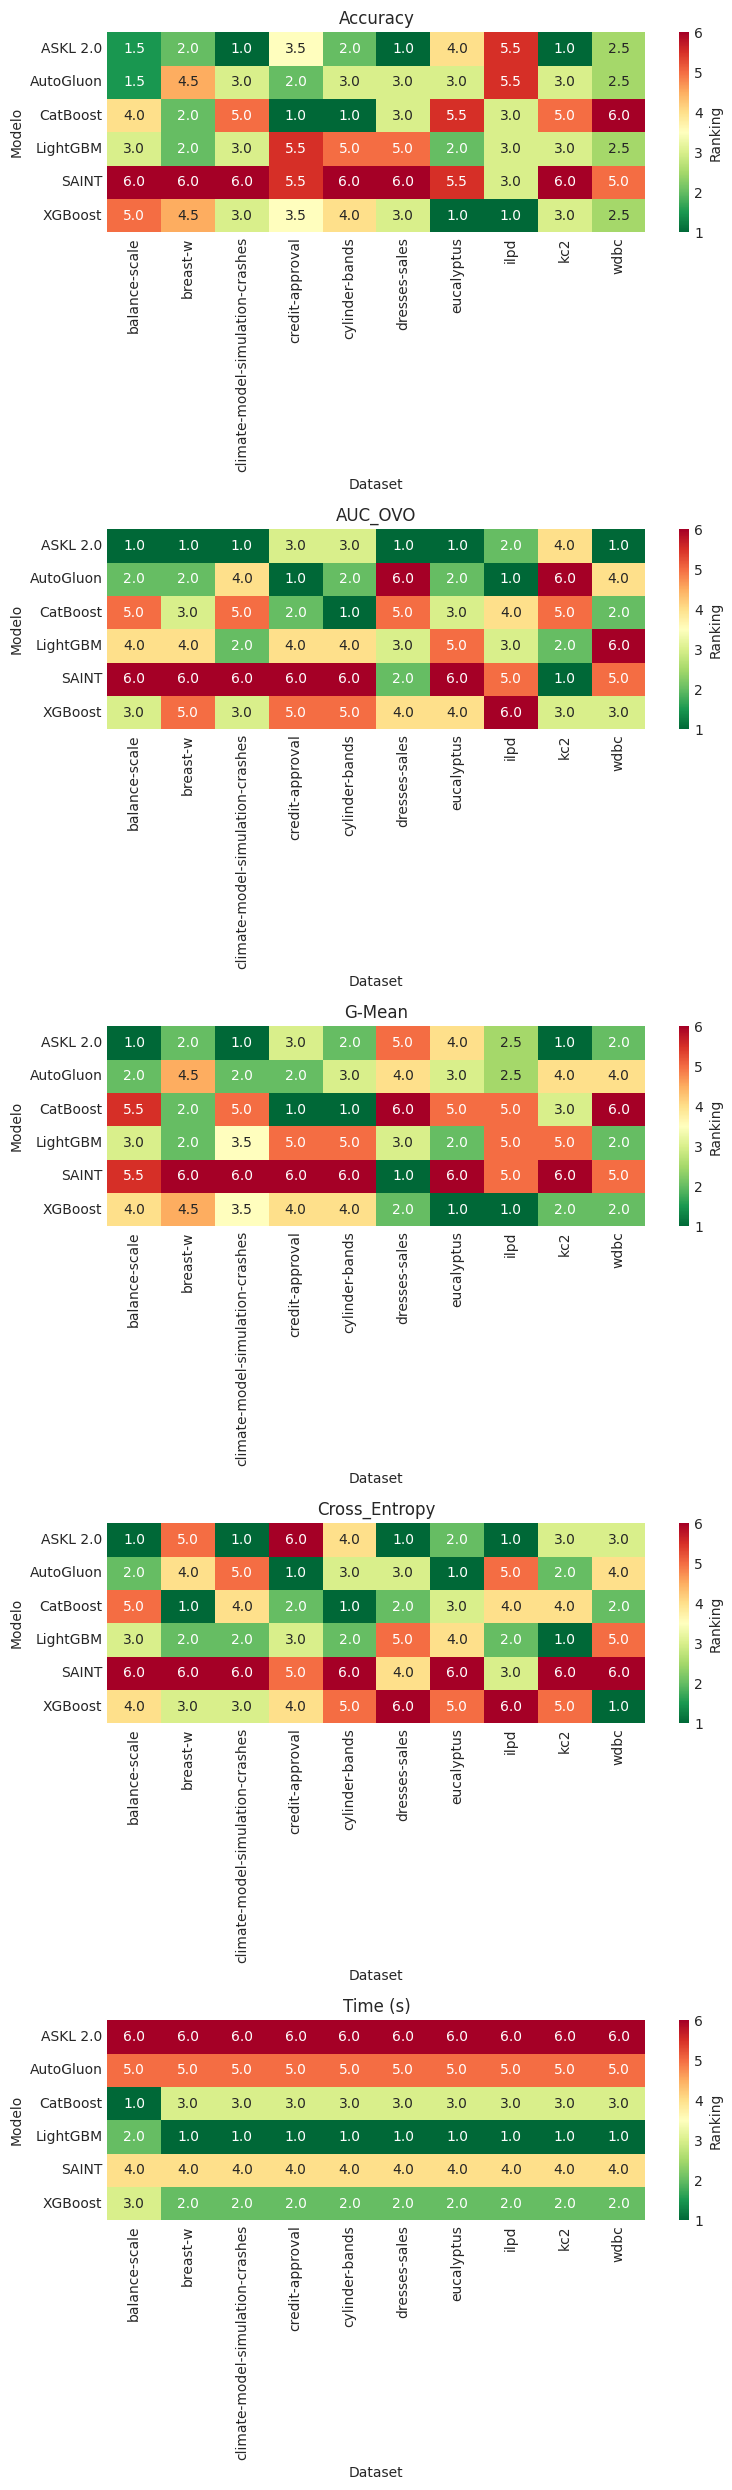

In [ ]:
ranking_metrics = [
    ('Accuracy', True),
    ('AUC_OVO', True),
    ('G-Mean', True),
    ('Cross_Entropy', False),
    ('Time (s)', False)
]

fig, axes = plt.subplots(len(ranking_metrics), 1, figsize=(8, 5 * len(ranking_metrics)))

for ax, (metric, maximize) in zip(np.atleast_1d(axes), ranking_metrics):
	pivot = results_df.pivot(index='Dataset', columns='Model', values=metric).dropna()
	if pivot.empty:
		ax.set_axis_off()
		ax.set_title(f'Sem dados: {metric}')
		continue

	ranks = pivot.apply(lambda row: (-row).rank() if maximize else row.rank(), axis=1)
	sns.heatmap(
		ranks.T,
		annot=True,
		fmt='.1f',
		cmap='RdYlGn_r',
		ax=ax,
		cbar_kws={'label': 'Ranking'}
	)
	ax.set_title(metric)
	ax.set_xlabel('Dataset')
	ax.set_ylabel('Modelo')

plt.tight_layout()
plt.show()

### Painel de métricas

Mostra barras com média e desvio-padrão de cada métrica por modelo. No caso do Tempo total, quanto menor, melhor.

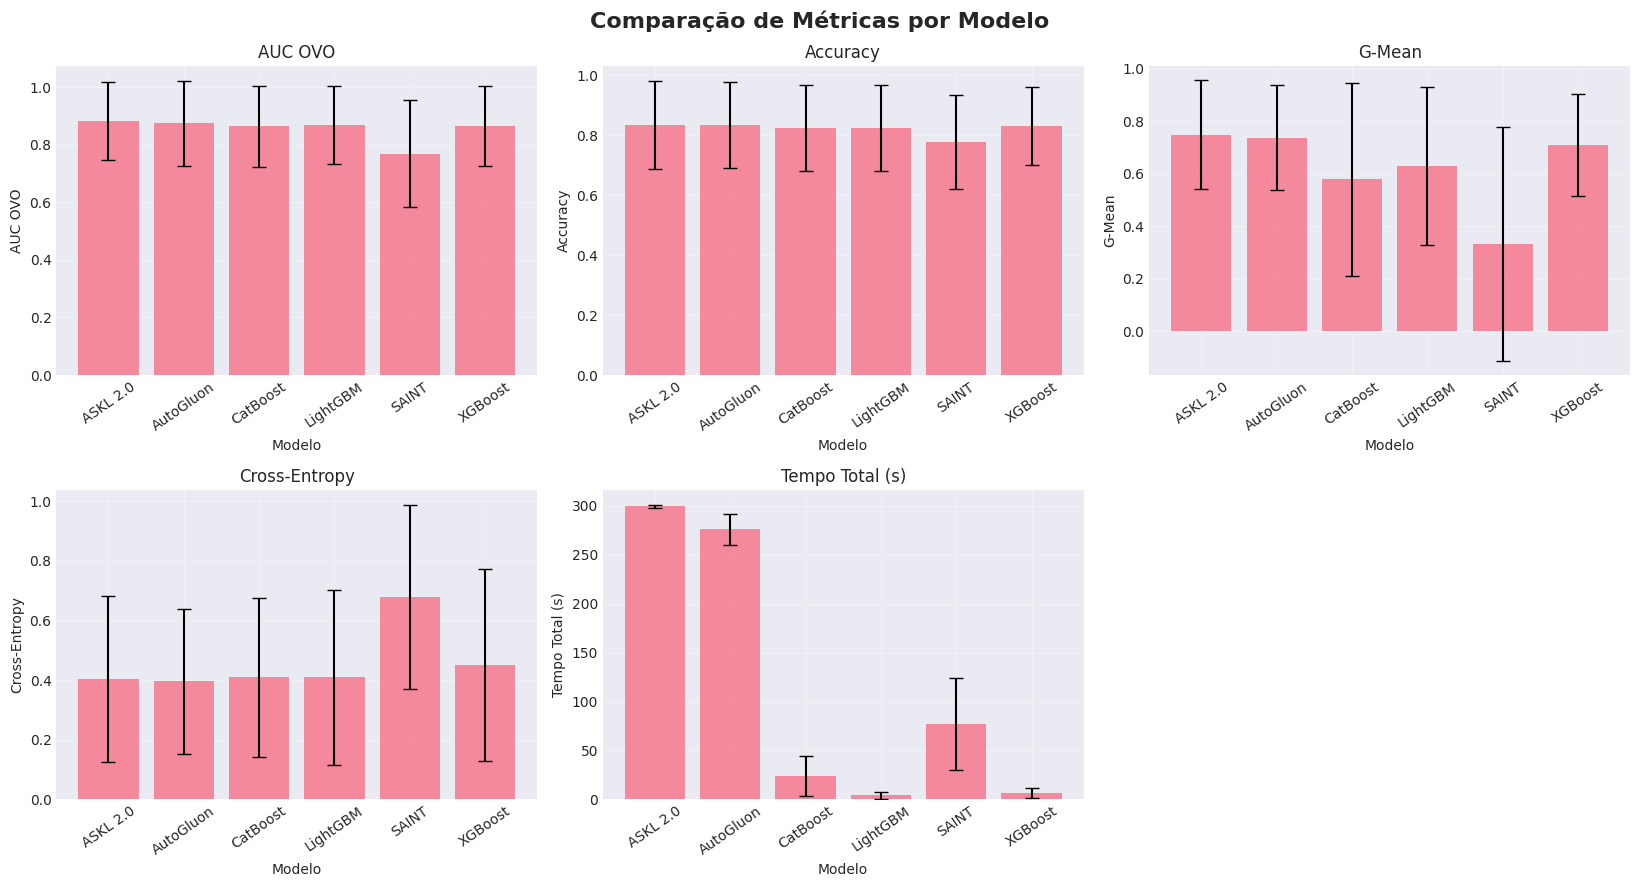

In [ ]:
metric_panels = [
    ('AUC_OVO', 'AUC OVO'),
    ('Accuracy', 'Accuracy'),
    ('G-Mean', 'G-Mean'),
    ('Cross_Entropy', 'Cross-Entropy'),
    ('Time (s)', 'Tempo Total (s)')
]

rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.5, rows * 4.5))
fig.suptitle('Comparação de Métricas por Modelo', fontsize=16, fontweight='bold')

for idx, (metric, title) in enumerate(metric_panels):
	r, c = divmod(idx, cols)
	ax = axes[r, c]
	data = results_df.groupby('Model')[metric].agg(['mean', 'std']).reset_index()
	ax.bar(data['Model'], data['mean'], yerr=data['std'], capsize=5, alpha=0.8)
	ax.set_title(title)
	ax.set_ylabel(title)
	ax.set_xlabel('Modelo')
	ax.tick_params(axis='x', rotation=35)
	ax.grid(True, alpha=0.3)

# remover subplot vazio
if len(metric_panels) < rows * cols:
	for k in range(len(metric_panels), rows * cols):
		fig.delaxes(axes.flatten()[k])

plt.tight_layout()
plt.show()


## Análise estatística (protocolo de Demšar)

Baseado no artigo *"Statistical Comparisons of Classifiers over Multiple Data Sets"*, realizamos a comparação estatística dos modelos seguindo o protocolo recomendado para múltiplos classificadores em múltiplos datasets:

1.  **Ranking:** Calculamos o posto (rank) de cada modelo para cada dataset.
2.  **Teste de Friedman (Iman-Davenport):** Verificamos se existe diferença significativa global entre os algoritmos.
    *   Hipótese Nula ($H_0$): Todos os algoritmos têm desempenho equivalente.
3.  **Teste de Nemenyi (Post-hoc):** Se $H_0$ for rejeitada, calculamos a Diferença Crítica (CD).
    *   Dois algoritmos são significativamente diferentes se a distância entre seus ranks médios for maior que a CD.
4.  **Visualização (CD Diagram):** Plotamos os ranks médios e conectamos modelos estatisticamente equivalentes.

## Teste de Friedman

O teste de Friedman é um teste não paramétrico para detectar diferenças em tratamentos (modelos) em múltiplas tentativas (datasets).
Hipótese Nula ($H_0$): Não há diferença significativa entre o desempenho dos modelos.

## Teste de Nemenyi

Como $H_0$ foi rejeitada, realizamos o teste de Nemenyi para identificar quais pares de modelos diferem significativamente.
Este teste compara as classificações médias de todos os pares de modelos.

### Critical Difference Diagram

O diagrama mostra a classificação média de cada modelo.
Modelos conectados por uma barra horizontal grossa não são estatisticamente diferentes (p > 0.05).


--- Análise Estatística para: AUC_OVO ---

Ranks Médios (menor é melhor):
Model
ASKL 2.0     1.8
AutoGluon    3.0
CatBoost     3.5
LightGBM     3.7
XGBoost      4.1
SAINT        4.9
dtype: float64

Teste de Friedman: Estatística=15.7143, p-value=7.7090e-03
H0 rejeitada: Existem diferenças significativas entre os modelos.

Teste de Nemenyi (p-values) [α=0.05]:
Diferenças significativas encontradas:
  ASKL 2.0 vs SAINT: p=2.8973e-03

Gerando Diagrama de Diferença Crítica...


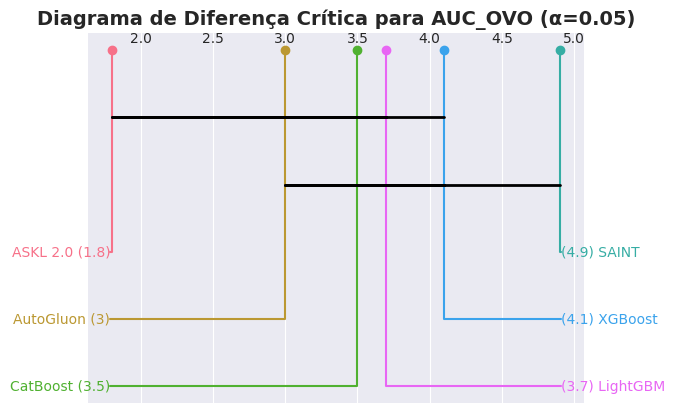


--- Análise Estatística para: Accuracy ---

Ranks Médios (menor é melhor):
Model
ASKL 2.0     2.40
XGBoost      3.05
AutoGluon    3.10
LightGBM     3.40
CatBoost     3.55
SAINT        5.50
dtype: float64

Teste de Friedman: Estatística=17.7866, p-value=3.2261e-03
H0 rejeitada: Existem diferenças significativas entre os modelos.

Teste de Nemenyi (p-values) [α=0.05]:
Diferenças significativas encontradas:
  ASKL 2.0 vs SAINT: p=2.8973e-03
  AutoGluon vs SAINT: p=4.7415e-02
  SAINT vs XGBoost: p=3.9943e-02

Gerando Diagrama de Diferença Crítica...


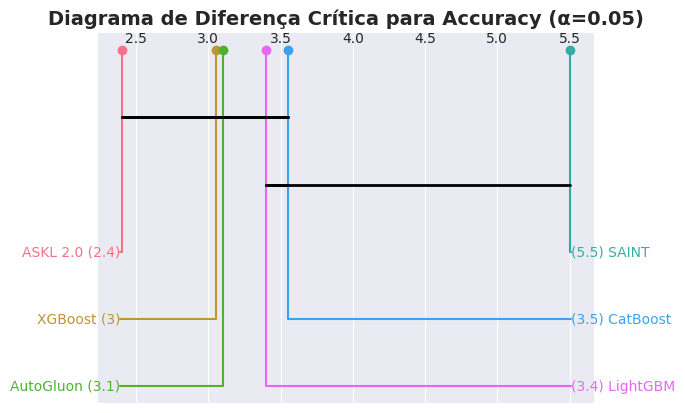


--- Análise Estatística para: G-Mean ---

Ranks Médios (menor é melhor):
Model
ASKL 2.0     2.35
XGBoost      2.80
AutoGluon    3.10
LightGBM     3.55
CatBoost     3.95
SAINT        5.25
dtype: float64

Teste de Friedman: Estatística=15.6886, p-value=7.7917e-03
H0 rejeitada: Existem diferenças significativas entre os modelos.

Teste de Nemenyi (p-values) [α=0.05]:
Diferenças significativas encontradas:
  ASKL 2.0 vs SAINT: p=6.9894e-03
  SAINT vs XGBoost: p=3.9943e-02

Gerando Diagrama de Diferença Crítica...


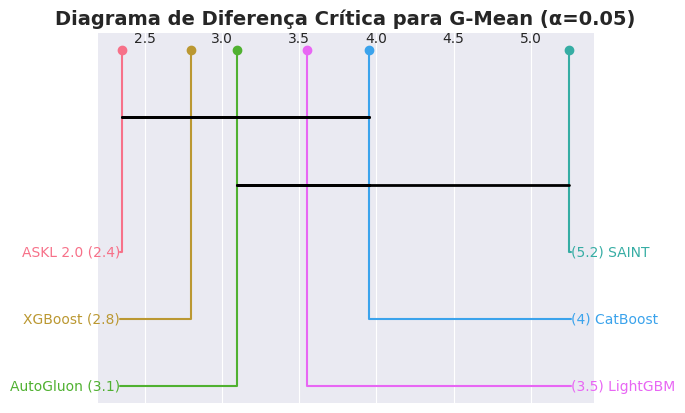

In [ ]:
import scikit_posthocs as sp
import scipy.stats as stats

ALPHA = 0.05

for metric in ['AUC_OVO', 'Accuracy', 'G-Mean']:
	print(f"\n--- Análise Estatística para: {metric} ---")

	# Pivotar: linhas=datasets, colunas=modelos
	pivot_df = results_df.pivot(index='Dataset', columns='Model', values=metric)

	# Ranking (maior valor = melhor rank, então ascending=False para rank 1 ser o melhor)
	ranks = pivot_df.rank(axis=1, ascending=False)
	avg_ranks = ranks.mean()

	print("\nRanks Médios (menor é melhor):")
	print(avg_ranks.sort_values())

	# Teste de Friedman
	args = [pivot_df[col] for col in pivot_df.columns]
	stat, p_value = stats.friedmanchisquare(*args)

	print(f"\nTeste de Friedman: Estatística={stat:.4f}, p-value={p_value:.4e}")

	reject_h0 = p_value < ALPHA
	if reject_h0:
		print("H0 rejeitada: Existem diferenças significativas entre os modelos.")
	else:
		print("H0 não rejeitada: Não há evidências suficientes de diferença.")
		continue

	# Post-hoc Nemenyi
	if reject_h0:
		nemenyi_matrix = sp.posthoc_nemenyi_friedman(pivot_df)
		
		print(f"\nTeste de Nemenyi (p-values) [α={ALPHA}]:")
		sig_pairs = []
		cols = nemenyi_matrix.columns
		for i in range(len(cols)):
			for j in range(i+1, len(cols)):
				p = nemenyi_matrix.iloc[i, j]
				if p < ALPHA:
					sig_pairs.append((cols[i], cols[j], p))
		
		if sig_pairs:
			print("Diferenças significativas encontradas:")
			for m1, m2, p in sig_pairs:
				print(f"  {m1} vs {m2}: p={p:.4e}")
		else:
			print("Nenhuma diferença par-a-par significativa encontrada pelo Nemenyi.")

		# CD Diagram
		print("\nGerando Diagrama de Diferença Crítica...")

		fig = sp.critical_difference_diagram(avg_ranks, nemenyi_matrix)
		plt.title(f'Diagrama de Diferença Crítica para {metric} (α={ALPHA})', fontsize=14, fontweight='bold')
		plt.show()